<span style="color:#1976d2; font-size:2.2em; font-weight:bold;">🔥 Projet London Fire Response</span>

<span style="color:#42a5f5; font-size:2em; font-weight:bold;">Exploration des données</span>

Ce notebook a pour but de charger, assembler et analyser rapidement les données brutes provenant de deux sources :

-les incidents signalés 

-les mobilisations des pompiers

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques Python</span>

In [128]:
import os                # Pour manipuler les chemins de fichiers
import pandas as pd      # Pour charger et analyser les données
import glob              # Pour lister automatiquement tous les fichiers d’un dossier
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns             # Visualisation statistique

In [129]:
# Pour afficher toutes les colonnes et tout explorer !
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

  <span style="color:#e91e63; font-size:1em; font-weight:bold;">2. Définition les chemins propres</span>

In [130]:
# Revenir au dossier parent
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Dossiers contenant les fichiers incidents et mobilisations
incidents_path = os.path.join(base_path, "data", "raw", "incidents")
mobilisations_path = os.path.join(base_path, "data", "raw", "mobilisations")

print("-Chemin incidents :", incidents_path)
print("-Chemin mobilisations :", mobilisations_path)

-Chemin incidents : c:\Users\9609241C\london-fire-response\data\raw\incidents
-Chemin mobilisations : c:\Users\9609241C\london-fire-response\data\raw\mobilisations


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3. Charger tous les fichiers incidents (.csv)  </span>

In [131]:
incident_files = glob.glob(os.path.join(incidents_path, "*.csv"))

# On charge tous les fichiers et on les regroupe
incidents = pd.concat([pd.read_csv(f) for f in incident_files], ignore_index=True)

# Aperçu rapide
print("Données incidents chargées !")
print(incidents.head())
print("-Nombre de lignes :", len(incidents))
print("-Nombre de colonnes :", len(incidents.columns))
print("-Colonnes :", incidents.columns.tolist())
print("-Types de données :", incidents.dtypes)

C:\Users\9609241C\AppData\Local\Temp\ipykernel_3596\233953251.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.concat([pd.read_csv(f) for f in incident_files], ignore_index=True)


Données incidents chargées !
  IncidentNumber DateOfCall  CalYear TimeOfCall  HourOfCall    IncidentGroup  \
0    235138081.0  01-Jan-09     2009   00:00:37           0  Special Service   
1         1091.0  01-Jan-09     2009   00:00:46           0  Special Service   
2         2091.0  01-Jan-09     2009   00:03:00           0             Fire   
3         3091.0  01-Jan-09     2009   00:04:27           0             Fire   
4         5091.0  01-Jan-09     2009   00:05:39           0             Fire   

  StopCodeDescription     SpecialServiceType PropertyCategory  \
0     Special Service                    RTC     Road Vehicle   
1     Special Service  Assist other agencies          Outdoor   
2      Secondary Fire                    NaN          Outdoor   
3      Secondary Fire                    NaN          Outdoor   
4      Secondary Fire                    NaN          Outdoor   

                                  PropertyType  \
0                                         Car    

> ## 📊 Observations de l'importation et exploration initiale des données `incidents`
* Les données ont bien été chargées (environ 1,8 million de lignes, 39 colonnes).
* Avertissement sur `IncidentNumber` : mélange de types (probablement des entiers et des chaînes).
* Beaucoup de colonnes sont de type texte (`object`), avec aussi des numériques (`int64`, `float64`), notamment pour les coûts, le nombre de pompes, les temps d’intervention, etc.
* Il y a plusieurs colonnes temporelles redondantes (`DateOfCall`, `TimeOfCall`, `HourOfCall`, `CalYear`) → à combiner.
* Les colonnes liées à la localisation sont riches : code postal, latitude/longitude, boroughs, wards…
* On observe des valeurs manquantes dans certaines colonnes (`UPRN`, `USRN`, `SecondPump...`).
* Quelques colonnes semblent redondantes ou doublées (`IncGeo_WardName` vs `IncGeo_WardNameNew`, `FRS` vs `ProperCase`).
* Il faudra convertir les dates en datetime, harmoniser les types, et potentiellement nettoyer les colonnes peu remplies ou inutiles.

<span style="color:#e91e63; font-size:1em; font-weight:bold;">4. Charger tous les fichiers mobilisations (.csv ou .xlsx) </span>

In [132]:
# Fichiers .csv et .xlsx
mobilisation_csv = glob.glob(os.path.join(mobilisations_path, "*.csv"))
mobilisation_xlsx = glob.glob(os.path.join(mobilisations_path, "*.xlsx"))

# Charger tout et regrouper
mobilisations = pd.concat(
    [pd.read_csv(f) for f in mobilisation_csv] + 
    [pd.read_excel(f) for f in mobilisation_xlsx],
    ignore_index=True
)

print(" Données mobilisations chargées !")
print(mobilisations.head())

C:\Users\9609241C\AppData\Local\Temp\ipykernel_3596\230581493.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mobilisations = pd.concat(


 Données mobilisations chargées !
    IncidentNumber  CalYear           BoroughName      WardName  HourOfCall  \
0  000004-01012021     2021              HARINGEY  Muswell Hill           0   
1  000005-01012021     2021             REDBRIDGE      MONKHAMS           0   
2  000006-01012021     2021  BARKING AND DAGENHAM       Village           0   
3  000007-01012021     2021            WANDSWORTH     West Hill           0   
4  000007-01012021     2021            WANDSWORTH     West Hill           0   

   ResourceMobilisationId Resource_Code PerformanceReporting  \
0                 5769249          A321                    1   
1                 5769250          F351                    1   
2                 5769251          F412                    1   
3                 5769252          H331                    1   
4                 5769253          G351                    2   

  DateAndTimeMobilised DateAndTimeMobile DateAndTimeArrived  \
0     01/01/2021 00:06  01/01/2021 00:07   

In [133]:
#Suite exploration mobilisations
print("-Nombre de lignes :", len(mobilisations))
print("-Nombre de colonnes :", len(mobilisations.columns))
print("-Colonnes :", mobilisations.columns.tolist())
print("-Types de données :", mobilisations.dtypes)

-Nombre de lignes : 2561435
-Nombre de colonnes : 24
-Colonnes : ['IncidentNumber', 'CalYear', 'BoroughName', 'WardName', 'HourOfCall', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code', 'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description']
-Types de données : IncidentNumber                      object
CalYear                              int64
BoroughName                         object
WardName                            object
HourOfCall                           int64
ResourceMobilisationId               int64
Resource_Code                       object
PerformanceReporting                object
DateAndTimeMobilised                object
DateAndTimeMobile                   obj

> ## 📊 Observations de l'importation et exploration initiale des données `mobilisations`
- d'apres le warning du chargement avec pd : présence de colonnes vides ou très mal renseignées dans certains fichiers du dataset.
-`DelayCode_Description` contient beaucoup de valeurs manquantes
- Faudra faire attention à la conversion des `IncidentNumber` notamment pr le join entre les 2 datasets !
- Les 4 colonnes temporelles 'DateAndTimeMobilised','DateAndTimeMobile' ,'DateAndTimeArrived' ,'DateAndTimeLeft': ont un format cohérent nécessitent un to_datetime().

IncidentNumber : etant  l'identifiant de l'incident
PumpOrder : ordre d’arrivée de l’engin 
ApplianceIdentifier / ApplianceCallSign : identifiants du véhicule
==> Plusieurs mobilisations sont donc liées à un même incident, ce qui créera des doublons d’incidents mais lignes uniques de mobilisation.

Pour ce qui des données de Localisation :
BoroughCode / BoroughName, DeployedFromStation_Code / DeployedFromStation_Name, StationGround
==> Les données  semblentmajoritairement complètes sur la géographie, avec des noms lisibles. Peu de valeurs nulles.

<span style="color:#e91e63; font-size:1em; font-weight:bold;">5. Jointure entre les data incidents et mobilisations </span>

In [134]:
# Harmoniser IncidentNumber dans les deux DataFrames
incidents['IncidentNumber'] = incidents['IncidentNumber'].astype(str).str.strip()
mobilisations['IncidentNumber'] = mobilisations['IncidentNumber'].astype(str).str.strip()

In [135]:
# Jointure sur l'ID IncidentNumber
df_jointure = mobilisations.merge(incidents, on="IncidentNumber", how="inner")

In [136]:
#Aperçu de la jointure:
df_jointure.head()
df_jointure.info()
df_jointure.shape
df_jointure.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538089 entries, 0 to 1538088
Data columns (total 62 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1538089 non-null  object        
 1   CalYear_x                               1538089 non-null  int64         
 2   BoroughName                             773072 non-null   object        
 3   WardName                                772197 non-null   object        
 4   HourOfCall_x                            1538089 non-null  int64         
 5   ResourceMobilisationId                  1538089 non-null  int64         
 6   Resource_Code                           1538089 non-null  object        
 7   PerformanceReporting                    1538089 non-null  object        
 8   DateAndTimeMobilised                    1538089 non-null  object        
 9   DateAndTimeMobile       

Index(['IncidentNumber', 'CalYear_x', 'BoroughName', 'WardName',
       'HourOfCall_x', 'ResourceMobilisationId', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds',
       'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned',
       'DeployedFromStation_Code', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code',
       'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description',
       'DateOfCall', 'CalYear_y', 'TimeOfCall', 'HourOfCall_y',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_

In [137]:
# Affichage de toutes les colonnes
print(df_jointure.columns.tolist())

['IncidentNumber', 'CalYear_x', 'BoroughName', 'WardName', 'HourOfCall_x', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code', 'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description', 'DateOfCall', 'CalYear_y', 'TimeOfCall', 'HourOfCall_y', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime', '

-Colonnes avec valeurs manquantes
Certaines colonnes ont un nombre important de valeurs manquantes, par exemple :
BoroughName, WardName, DateAndTimeReturned seulement 4 valeurs non-nulles : à vérifier, peut-être colonne à ignorer.
DelayCodeId et DelayCode_Description,Postcode_full, Latitude, Longitude ont aussi beaucoup de manquants 

-Colonnes à doublons ou similaire
Il y a colonnes CalYear_x et CalYear_y, HourOfCall_x et HourOfCall_y : 
-> faut vérifier si leur contenu est idem pour n'en garder 1 !

-Types de données
Date/heure stockées en object pour plusieurs colonnes (DateAndTimeMobilised, .. ==> à formater!

-Suggestions d’actions possibles
Nettoyage

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6. Vérifier les doublons :</span>

In [138]:
print("\n Les colonnes issues de la jointure avec suffixes _x et _y sont :")
colonnes_x = [col for col in df_jointure.columns if col.endswith('_x')]
colonnes_y = [col for col in df_jointure.columns if col.endswith('_y')]
print("Colonnes _x :", colonnes_x)
print("Colonnes _y :", colonnes_y)


 Les colonnes issues de la jointure avec suffixes _x et _y sont :
Colonnes _x : ['CalYear_x', 'HourOfCall_x']
Colonnes _y : ['CalYear_y', 'HourOfCall_y']


In [139]:
# Comparaison des colonnes issues de la jointure pour vérifier si identique
for col_x in ['CalYear_x', 'HourOfCall_x']:
    col_y = col_x[:-2] + '_y'
    comp = (df_jointure[col_x] == df_jointure[col_y]) | (df_jointure[col_x].isna() & df_jointure[col_y].isna())
    pct_identique = comp.mean() * 100
    print(f"Pour {col_x} vs {col_y} : {pct_identique:.2f}% des valeurs sont identiques")

Pour CalYear_x vs CalYear_y : 100.00% des valeurs sont identiques
Pour HourOfCall_x vs HourOfCall_y : 100.00% des valeurs sont identiques


In [140]:
colonnes_a_supprimer = ['CalYear_y', 'HourOfCall_y']

# On Supprime les colonnes uniquement si elles existent, sinon ignorer
df = df_jointure.drop(columns=colonnes_a_supprimer, errors='ignore')

# Renommage des colonnes _x si elles existent dans df
colonnes_rename = {}
if 'CalYear_x' in df.columns:
    colonnes_rename['CalYear_x'] = 'CalYear'
if 'HourOfCall_x' in df.columns:
    colonnes_rename['HourOfCall_x'] = 'HourOfCall'

df.rename(columns=colonnes_rename, inplace=True)

# Affecter à df_jointure
df_jointure = df

# Aperçu global
print("Dimensions du DataFrame :", df.shape)
print("\nTypes et non-null par colonne :")
print(df.info())
print("\nQuelques lignes du DataFrame :")
print(df.head())

Dimensions du DataFrame : (1538089, 60)

Types et non-null par colonne :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538089 entries, 0 to 1538088
Data columns (total 60 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1538089 non-null  object        
 1   CalYear                                 1538089 non-null  int64         
 2   BoroughName                             773072 non-null   object        
 3   WardName                                772197 non-null   object        
 4   HourOfCall                              1538089 non-null  int64         
 5   ResourceMobilisationId                  1538089 non-null  int64         
 6   Resource_Code                           1538089 non-null  object        
 7   PerformanceReporting                    1538089 non-null  object        
 8   DateAndTimeMobilised         

In [141]:
#Analyse des valeurs manquantes:
# Calcul du pourcentage de valeurs manquantes pour chaque colonne
missing_pct = df.isnull().mean() * 100

# Affichage des colonnes où il y a au moins une valeur manquante, triées du plus au moins
print("Colonnes avec des valeurs manquantes (en %), triées par ordre décroissant :")
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

Colonnes avec des valeurs manquantes (en %), triées par ordre décroissant :
DateAndTimeReturned                       99.999740
SpecialServiceType                        76.974869
DelayCodeId                               75.782416
DelayCode_Description                     75.782416
Longitude                                 59.537582
Northing_m                                59.537582
Easting_m                                 59.537582
Latitude                                  59.537582
Postcode_full                             59.537582
WardName                                  49.795038
BoroughName                               49.738149
SecondPumpArriving_DeployedFromStation    39.513058
SecondPumpArriving_AttendanceTime         39.511953
TravelTimeSeconds                          0.620445
TurnoutTimeSeconds                         0.613814
DateAndTimeMobile                          0.611733
DeployedFromLocation                       0.081985
IncGeo_WardCode                         

In [142]:
# Colonnes avec format "DD/MM/YYYY HH:MM"
cols_ddmmyyyy_hhmm = [
    'DateAndTimeMobilised',
    'DateAndTimeMobile',
    'DateAndTimeArrived',
    'DateAndTimeLeft',
]

for col in cols_ddmmyyyy_hhmm:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y %H:%M', errors='coerce')

# Colonne DateOfCall au format "DD-Mon-YY" (ex: 01-Jan-21)
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], format='%d-%b-%y', errors='coerce')

# Colonne TimeOfCall : heures (HH:MM:SS)
df['TimeOfCall'] = pd.to_timedelta(df['TimeOfCall'], errors='coerce')

# Vérification rapide
print(df[cols_ddmmyyyy_hhmm + ['DateOfCall', 'TimeOfCall']].dtypes)


DateAndTimeMobilised     datetime64[ns]
DateAndTimeMobile        datetime64[ns]
DateAndTimeArrived       datetime64[ns]
DateAndTimeLeft          datetime64[ns]
DateOfCall               datetime64[ns]
TimeOfCall              timedelta64[ns]
dtype: object


In [143]:
# Statistiques descriptives des variables num
print("\nStatistiques descriptives (numériques) :")
print(df.describe())


Statistiques descriptives (numériques) :
            CalYear    HourOfCall  ResourceMobilisationId  \
count  1.538089e+06  1.538089e+06            1.538089e+06   
mean   2.020360e+03  1.339901e+01            5.764446e+06   
min    2.015000e+03  0.000000e+00            4.596357e+06   
25%    2.018000e+03  9.000000e+00            5.172816e+06   
50%    2.021000e+03  1.400000e+01            5.774676e+06   
75%    2.023000e+03  1.900000e+01            6.345818e+06   
max    2.025000e+03  2.300000e+01            6.939735e+06   
std    2.739782e+00  6.364122e+00            6.745182e+05   

                DateAndTimeMobilised              DateAndTimeMobile  \
count                        1538089                        1528680   
mean   2020-11-12 09:08:28.424776960  2020-11-14 08:54:03.658617344   
min              2015-11-17 02:20:23            2015-11-17 02:22:22   
25%              2018-07-06 18:53:18     2018-07-08 17:17:22.500000   
50%              2021-01-10 21:25:00            2021-

In [144]:
# Analyse des variables catégorielles
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nColonnes catégorielles ({len(cat_cols)}): {cat_cols}")
for col in cat_cols:
    print(f"\nValeurs uniques dans {col} : {df[col].nunique()}")
    print(df[col].value_counts(dropna=False).head(10))


Colonnes catégorielles (29): ['IncidentNumber', 'BoroughName', 'WardName', 'Resource_Code', 'PerformanceReporting', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', 'PlusCode_Description', 'DelayCode_Description', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation']

Valeurs uniques dans IncidentNumber : 994727
IncidentNumber
084944-29052024    52
127410-07082022    46
093520-26062022    37
059958-30042023    36
002207-04012025    35
110740-19072022    34
087189-15062023    30
081374-07062023    30
002059-06012021    24
020910-13022022    24
Name: count, dtype: int64

Valeurs uniques dans BoroughName : 33
Bo

7. Exploration temporelle — vers une analyse en série temporelle

Objectif : analyser la distribution des appels dans le temps pour détecter des saisonnalités, pics, tendances.

C:\Users\9609241C\AppData\Local\Temp\ipykernel_3596\2742269248.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\9609241C\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


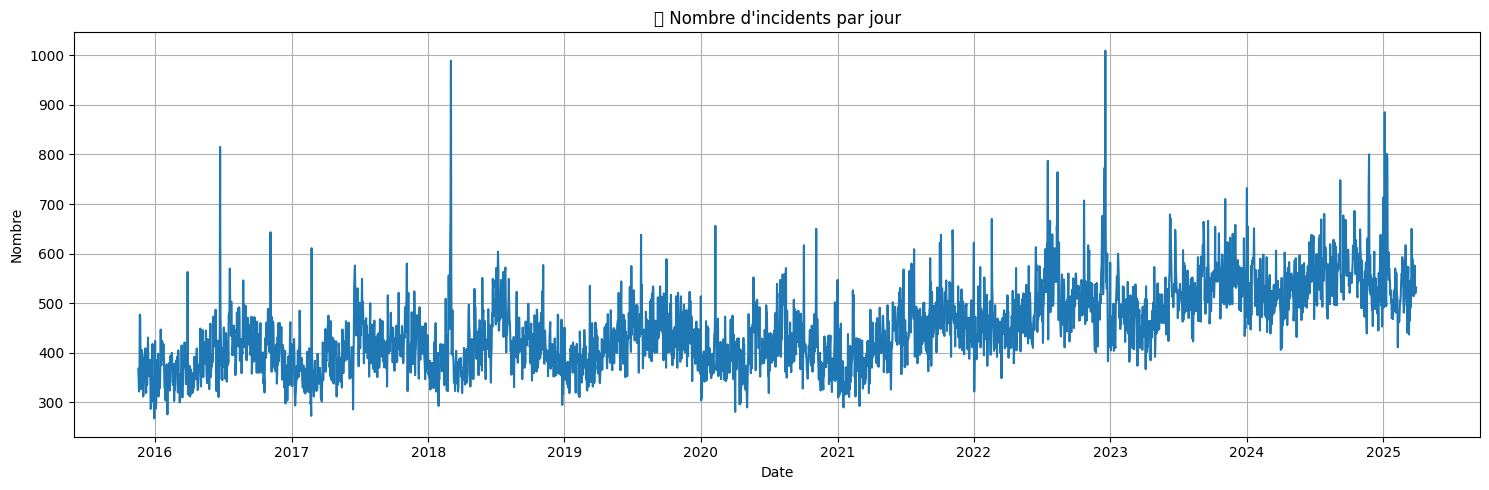

In [145]:
# Index temps
df['Date'] = df['DateAndTimeMobilised'].dt.date

# Incidents par jour
df_daily = df.groupby('Date').size()
plt.figure(figsize=(15,5))
df_daily.plot()
plt.title("📈 Nombre d'incidents par jour")
plt.xlabel("Date")
plt.ylabel("Nombre")
plt.grid(True)
plt.tight_layout()
plt.show()

Ce qu’on observe :
Tendance générale à la hausse du nombre d’incidents de 2016 à 2025.

Pics très marqués à certaines dates (notamment en 2018 et 2023) — à explorer !

Un certain rythme saisonnier visible (oscillations régulières).

Peu ou pas de rupture nette, ce qui est bon pour des modèles de séries temporelles classiques

C:\Users\9609241C\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


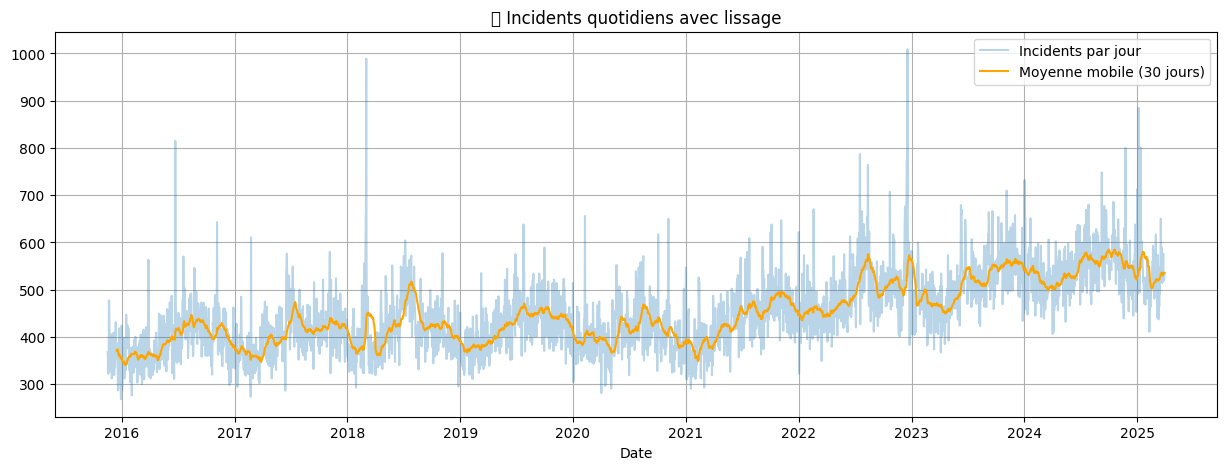

In [146]:
#1. Lissage de la saisonnalité annuelle
df_daily_smooth = df_daily.rolling(window=30).mean()

plt.figure(figsize=(15,5))
df_daily.plot(alpha=0.3, label='Incidents par jour')
df_daily_smooth.plot(label='Moyenne mobile (30 jours)', color='orange')
plt.title("📉 Incidents quotidiens avec lissage")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\9609241C\AppData\Local\Temp\ipykernel_3596\3591015204.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M').size()
C:\Users\9609241C\AppData\Local\Temp\ipykernel_3596\3591015204.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\9609241C\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\9609241C\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


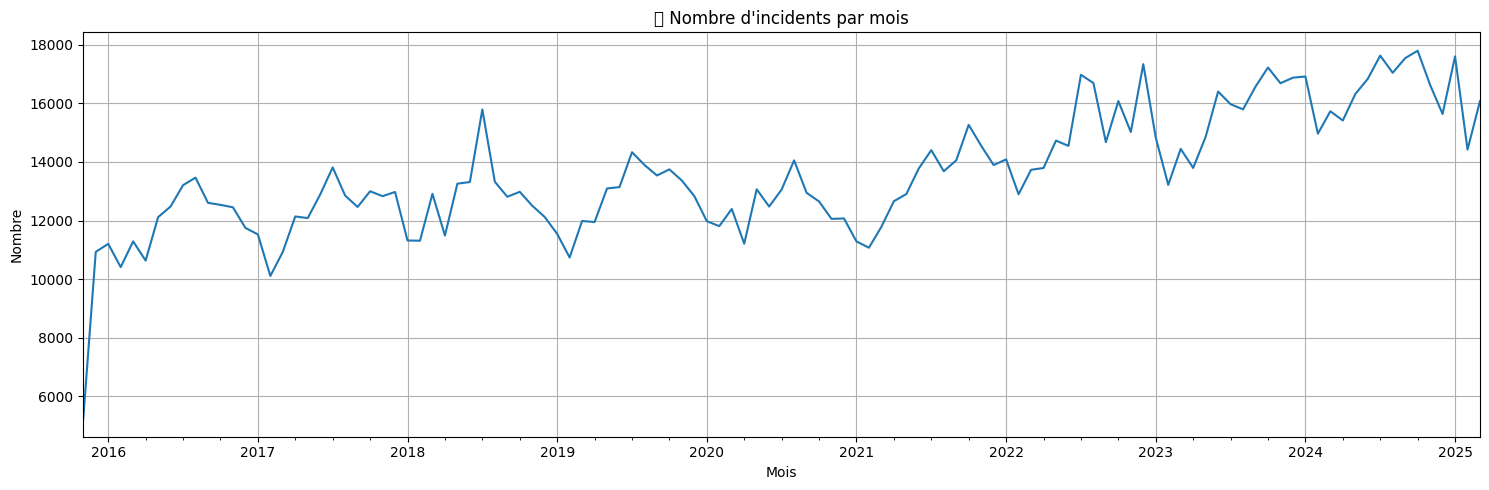

In [147]:
# 2. Aggrégation mensuelle :

# Refixer index datetime
df = df.set_index('DateAndTimeMobilised')
df_num = df.select_dtypes(include='number')

# Agrégation mensuelle
monthly_counts = df.resample('M').size()
plt.figure(figsize=(15,5))
monthly_counts.plot()
plt.title("📈 Nombre d'incidents par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre")
plt.grid(True)
plt.tight_layout()
plt.show()

1. Tendance générale à la hausse
De 2016 à 2025, le nombre total d'incidents mensuels augmente progressivement !

2. Saisonnalité annuelle claire
On observe des creux et des pics réguliers chaque année, ce qui suggère une saisonnalité!
* certaines années montrent un pic autour de l’hiver ou du début d’année, suivi d’un creux en été ou fin d’année. Il faudrait une analyse plus précise (ex : moyenne par mois de l'année) pour confirmer.

3.  Pics anormaux ponctuels
Certains mois sortent du lot avec un niveau d’incidents très supérieur (ex. vers mi-2018, mi-2022, début 2023).
Ces valeurs aberrantes peuvent être liées à :
Un événement exceptionnel 
Un problème de qualité de données (doublons, sur-enregistrement…).

4. Petits creux inattendus
Par exemple début 2018 ou mi-2020, avec une chute visible.
Ça peut correspondre à des périodes de vacances, de confinement (COVID ?), ou ?

